In [3]:
pip install openpifpaf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.3/202.3 kB 3.3 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 4.1 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Using cached torch-1.13.1-cp310-cp310-manylinux1_x86_64.whl.metadata (24 kB)
  Using cached nvidia_cuda_runtime_cu11-11.7.99-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu11-11.10.3.66-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cuda_nvrtc_cu11-11.7.99-2-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
Using cached torch-1.13.1-cp310-cp310-manylinux1_x86_64.whl (887.5 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 9.9 MB/s eta 0:00:00:00:0100:01
Using cached nvidia_cublas_c

In [108]:
import openpifpaf
import torch
import PIL
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from tqdm import tqdm 
import pandas as pd

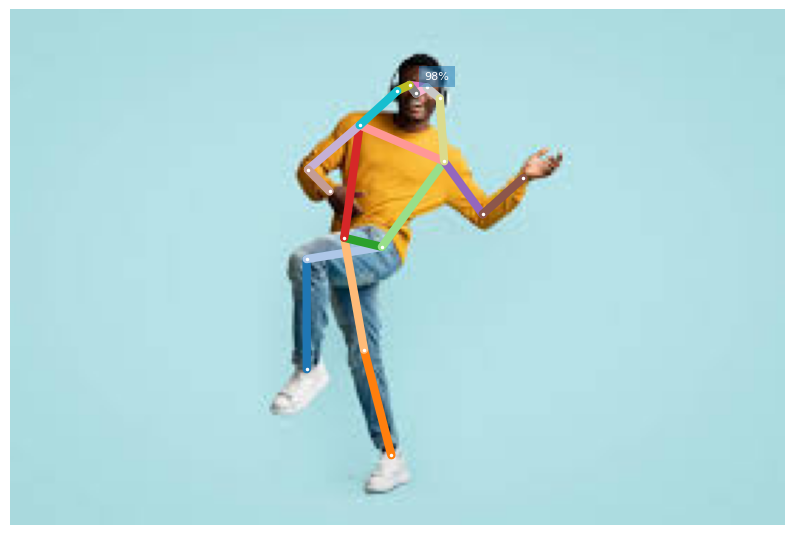

In [89]:
def predict_keypoints(image_path):
    # Load the image
    image = Image.open(image_path)
    image_np = np.array(image)
    
    # Initialize the predictor
    predictor = openpifpaf.Predictor(checkpoint='shufflenetv2k30')
    predictions, _, _ = predictor.numpy_image(image_np)
    
    # Annotate the image with predictions
    annotation_painter = openpifpaf.show.AnnotationPainter()
    fig, ax = plt.subplots(figsize=(10, 10))
    annotation_painter.annotations(ax, predictions)
    
    # Show the image
    ax.imshow(image)
    ax.axis('off')
    plt.show()

    keypoints = predictions
    
    return keypoints

# Specify the path to your image
image_path = 'Dancer.jpg'
keypoints = predict_keypoints(image_path)

In [90]:
print(keypoints)

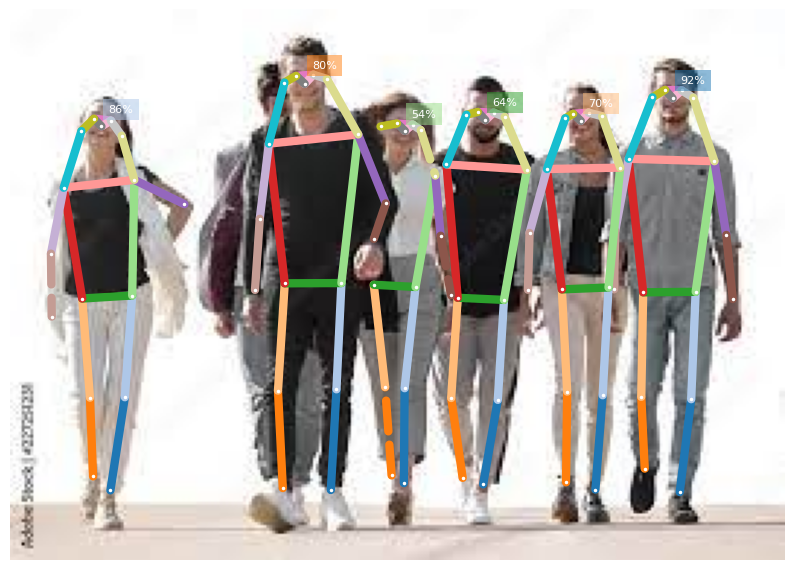

In [91]:
keypoints_multiple = predict_keypoints('Multiple.jpg')

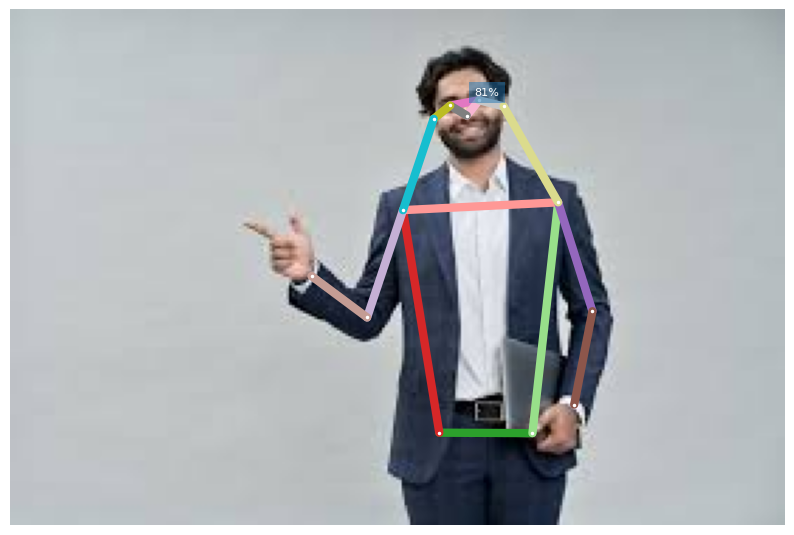

In [92]:
keypoints_upper = predict_keypoints('upper.jpg')

In [93]:
keypoints_upper

### Body area calculation

In [94]:
def shoelace_formula(points):
    """Calculate the area of a polygon using the Shoelace formula."""
    x = points[:, 0]
    y = points[:, 1]
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

def estimate_limb_area(length, ratio):
    """Estimate the area of a limb as a cuboid using the length and ratio."""
    height = length
    circumference = height * ratio
    width_depth = circumference / 4  # Assuming the width and depth are equal for simplicity
    return height * width_depth  # Area of one side of the cuboid

def calculate_total_area_from_predictions(predictions):
    # Hardcoded ratios based on the provided image
    ratios = {
        'lower_leg': 0.25464791,
        'upper_leg': 0.34059158,
        'upper_arm': 0.41115027,
        'lower_arm': 0.12599766,
        # You can add head, neck, torso, etc. if you have specific ratios for them
    }
    
    total_area = 0.0  # Initialize total area for all people

    # Iterate over each detected person's predictions
    for pred in predictions:
        keypoints = pred.data  # keypoints for the current person
        
        # Calculate limb lengths and areas as before (the code remains the same)
        upper_arm_length = np.linalg.norm(keypoints[6] - keypoints[8])  # Shoulder to elbow
        lower_arm_length = np.linalg.norm(keypoints[8] - keypoints[10])  # Elbow to wrist
        upper_leg_length = np.linalg.norm(keypoints[12] - keypoints[14])  # Hip to knee
        lower_leg_length = np.linalg.norm(keypoints[14] - keypoints[16])  # Knee to ankle

        # Calculate limb areas
        upper_arm_area = estimate_limb_area(upper_arm_length, ratios['upper_arm'])
        lower_arm_area = estimate_limb_area(lower_arm_length, ratios['lower_arm'])
        upper_leg_area = estimate_limb_area(upper_leg_length, ratios['upper_leg'])
        lower_leg_area = estimate_limb_area(lower_leg_length, ratios['lower_leg'])
        
        # Calculate torso area as a rectangle for simplicity
        torso_width = np.linalg.norm(keypoints[6] - keypoints[12])  # Shoulder to hip
        torso_height = np.linalg.norm(keypoints[6] - keypoints[1])  # Shoulder to top of head
        torso_area = torso_width * torso_height
        
        # Sum areas for the current person
        person_area = torso_area + upper_arm_area + lower_arm_area + upper_leg_area + lower_leg_area
        
        # Add current person's area to the total area
        total_area += person_area
    
    return total_area



In [95]:
# Calculate the total body area from predictions
total_body_area = calculate_total_area_from_predictions(keypoints)
print(f"Total Body Area: {total_body_area}")

Total Body Area: 1398.1933381017811


In [96]:
# Calculate the total body area from predictions
total_body_area = calculate_total_area_from_predictions(keypoints_multiple)
print(f"Total Body Area: {total_body_area}")

Total Body Area: 33250.98155760125


In [97]:
# Calculate the total body area from predictions
total_body_area = calculate_total_area_from_predictions(keypoints_upper)
print(f"Total Body Area: {total_body_area}")

Total Body Area: 8166.7769795225795


In [98]:
def max_single_person_confidence(predictions):
    """Returns the highest confidence score for the presence of at least one person."""
    max_confidence = 0.0
    for pred in predictions:
        person_confidence = max(pred.data[:, 2])  # Confidence scores are in the third column of the data
        max_confidence = max(max_confidence, person_confidence)
    return max_confidence

def max_keypoints_percentage(predictions, total_keypoints=17):
    """Returns the percentage of non-face keypoints detected for the person with the most keypoints."""
    face_keypoint_indices = [0, 1, 2, 3, 4]  # Indices for nose, eyes, and ears
    max_detected_keypoints = 0
    
    for pred in predictions:
        non_face_keypoints = np.delete(pred.data, face_keypoint_indices, axis=0)  # Remove face keypoints
        detected_keypoints = np.sum(non_face_keypoints[:, 2] > 0)  # Count non-face keypoints with confidence greater than 0
        max_detected_keypoints = max(max_detected_keypoints, detected_keypoints)
    
    # Adjust the total_keypoints by subtracting the number of face keypoints
    adjusted_total_keypoints = total_keypoints - len(face_keypoint_indices)
    
    return max_detected_keypoints / adjusted_total_keypoints

def analyze_predictions(predictions):
    """Runs all analyses on the predictions and returns the results."""
    if not predictions:
        return {
            'max_confidence': 0.0,
            'keypoints_percentage': 0.0,
            'total_area': 0.0
        }
    
    # Calculate the maximum confidence for the presence of at least one person
    max_conf = max_single_person_confidence(predictions)
    
    # Calculate the maximum percentage of keypoints detected for a person
    keypoints_perc = max_keypoints_percentage(predictions)
    
    # Calculate the total body area from predictions
    total_area = calculate_total_area_from_predictions(predictions)
    
    return {
        'max_confidence': max_conf,
        'keypoints_percentage': keypoints_perc,
        'total_area': total_area
    }

In [99]:
# Analyze the predictions
analysis_results = analyze_predictions(keypoints)
print(f"Analysis Results: {analysis_results}")

Analysis Results: {'max_confidence': 0.9995289, 'keypoints_percentage': 1.0, 'total_area': 1398.1933381017811}


In [100]:
# Analyze the predictions
analysis_results = analyze_predictions(keypoints_multiple)
print(f"Analysis Results: {analysis_results}")

Analysis Results: {'max_confidence': 0.99888283, 'keypoints_percentage': 1.0, 'total_area': 33250.98155760125}


In [101]:
# Analyze the predictions
analysis_results = analyze_predictions(keypoints_upper)
print(f"Analysis Results: {analysis_results}")

Analysis Results: {'max_confidence': 0.9992148, 'keypoints_percentage': 0.6666666666666666, 'total_area': 8166.7769795225795}


In [102]:
def analyze_video_for_best_frame(video_path):
    cap = cv2.VideoCapture(video_path)
    # Initialize the predictor
    predictor = openpifpaf.Predictor(checkpoint='shufflenetv2k30')
    if not cap.isOpened():
        raise IOError("Error: Could not open video.")
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    selected_frames = np.linspace(0, frame_count - 1, 5).astype(int)
    
    highest_confidence = 0
    best_frame_analysis = {'max_confidence': 0, 'keypoints_percentage': 0, 'total_area': 0}
    for frame_idx in selected_frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret:
            print(f"Warning: Could not read frame {frame_idx}. Skipping.")
            continue
        
        # Convert the frame to an RGB image
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image_np = np.array(image)

        predictions, _, _ = predictor.numpy_image(image_np)
        
        # Analyze the predictions for the current frame
        frame_analysis = analyze_predictions(predictions)
        frame_confidence = frame_analysis['max_confidence']
        
        # Check if this frame has the highest max confidence so far
        if frame_confidence > highest_confidence:
            highest_confidence = frame_confidence
            best_frame_analysis = frame_analysis

    # Apply additional conditions
    if best_frame_analysis['max_confidence'] < 0.5 or best_frame_analysis['keypoints_percentage'] <= 0.5:
        best_frame_analysis['keypoints_percentage'] = 0
        best_frame_analysis['total_area'] = 0
    
    cap.release()
    return best_frame_analysis

In [103]:
video_path = 'AlgonautsVideos268_All_30fpsmax/0001_0-0-1-6-7-2-8-0-17500167280.mp4'
# Initialize your OpenPifPaf predictor here
predictor = openpifpaf.Predictor(checkpoint='shufflenetv2k30')
best_frame_results = analyze_video_for_best_frame(video_path)
print(f"Best Frame Analysis: {best_frame_results}")

Best Frame Analysis: {'max_confidence': 0.7690322, 'keypoints_percentage': 0, 'total_area': 0}


In [106]:
def classify_folder_body(folder_path):
    video_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.mp4')]
    data = []
    
    # Initialize the OpenPifPaf predictor
    predictor = openpifpaf.Predictor(checkpoint='shufflenetv2k30')
    
    # Wrap video_files with tqdm for progress tracking
    for video_file in tqdm(video_files, desc='Analyzing Body in Videos'):
        video_id = video_file[:4]  # Extract video ID from filename
        video_path = os.path.join(folder_path, video_file)
        
        # Analyze the video and get results for the best frame
        best_frame_results = analyze_video_for_best_frame(video_path)
        
        # Append the results with the video ID
        data.append([video_id, best_frame_results['max_confidence'], best_frame_results['keypoints_percentage'], best_frame_results['total_area']])
    
    # Create a DataFrame with the results
    df = pd.DataFrame(data, columns=['Video ID', 'Max Confidence', 'Keypoints Percentage', 'Total Area'])
    return df

In [109]:
# Example usage
folder_path = 'AlgonautsVideos268_All_30fpsmax'
df = classify_folder_body(folder_path)
print(df)

Analyzing Body in Videos: 100%|██████████| 1102/1102 [15:57<00:00,  1.15it/s]

     Video ID  Max Confidence  Keypoints Percentage   Total Area
0        1012        0.000000              0.000000     0.000000
1        0284        0.000000              0.000000     0.000000
2        0039        0.000000              0.000000     0.000000
3        0853        0.998485              0.833333  5263.780141
4        1035        0.000000              0.000000     0.000000
...       ...             ...                   ...          ...
1097     0445        0.000000              0.000000     0.000000
1098     0542        0.000000              0.000000     0.000000
1099     0565        0.999192              0.000000     0.000000
1100     1003        0.000000              0.000000     0.000000
1101     0619        0.998981              0.000000     0.000000

[1102 rows x 4 columns]


In [110]:
# Assuming df_scenes is your DataFrame variable name
df.to_csv('df_bodies.csv', index=False)